In [1]:
import pymysql
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


### xAire_CCCB

In [7]:
connection_cccb = pymysql.connect(host='localhost',
                             user='citizensociallab',
                             password='experiments',
                             db='xAire_CCCB',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

df_users_cccb = pd.read_sql_query('SELECT * FROM game_user', connection_cccb)
df_users_round_cccb = pd.read_sql_query('SELECT * FROM game_userronda', connection_cccb)
df_games_cccb = pd.read_sql_query('SELECT * FROM game_partida', connection_cccb)
df_rounds_cccb = pd.read_sql_query('SELECT * FROM game_ronda', connection_cccb)
df_pollution_cccb = pd.read_sql_query('SELECT * FROM game_pollution', connection_cccb)

print('Total games CCCB: {}' .format(df_games_cccb.shape[0]))


# Experiment
df_games_cccb['experiment']= df_games_cccb['experiment'] + '_cccb'

# User identifiers
for index, row in df_users_cccb.iterrows():
    df_users_cccb.loc[index, 'id'] = row['id'] + 1000
    df_users_cccb.loc[index, 'partida_id'] = row['partida_id'] + 1000
    
# User round identifiers
for index, row in df_users_round_cccb.iterrows():
    df_users_round_cccb.loc[index, 'id'] = row['id'] + 1000
    df_users_round_cccb.loc[index, 'user_id'] = row['user_id'] + 1000
    df_users_round_cccb.loc[index, 'ronda_id'] = row['ronda_id'] + 1000

# Game identifiers
for index, row in df_games_cccb.iterrows():
    df_games_cccb.loc[index, 'id'] = row['id'] + 1000
    
# Round identifiers
for index, row in df_rounds_cccb.iterrows():
    df_rounds_cccb.loc[index, 'id'] = row['id'] + 1000
    df_rounds_cccb.loc[index, 'partida_id'] = row['partida_id'] + 1000

# Evolution of game
evolution_list = []
for index, row in df_games_cccb.iterrows():
    #print(df_rounds_cccb)
    evolution_list.append(np.array(df_rounds_cccb[df_rounds_cccb['partida_id']==row['id']].sort_values(by ='num_ronda')['bucket_final_ronda']))
    
df_evolution = pd.DataFrame(evolution_list, 
                            columns=['R1', 'R2', 'R3', 'R4', 'R5', 
                                     'R6', 'R7', 'R8', 'R9', 'R10'])

df_games_cccb['target_distance'] = evolution_list
df_games_cccb = pd.concat([df_games_cccb, df_evolution], axis=1, sort=False)

# Valid games
df_games_cccb_valid = df_games_cccb[df_games_cccb['comentari']!= 'NO_VALID']
df_games_cccb_no_valid = df_games_cccb[df_games_cccb['comentari']=='NO_VALID']

print('Total valid games CCCB: {}' .format(df_games_cccb_valid.shape[0]))
print('Total no valid games CCCB: {}' .format(df_games_cccb_no_valid.shape[0]))

# Users
print('Total users CCCB: {}' .format(df_users_cccb.shape[0]))

# Contribution users
contribution_list = []
for index, row in df_users_cccb.iterrows():
    contribution_list.append(np.array(df_users_round_cccb[df_users_round_cccb['user_id']==row['id']].sort_values(by ='ronda_id')['seleccio']))

df_users_cccb['contributions'] = contribution_list

df_contributions = pd.DataFrame(contribution_list, 
                            columns=['R1', 'R2', 'R3', 'R4', 'R5', 
                                     'R6', 'R7', 'R8', 'R9', 'R10'])

df_users_cccb = pd.concat([df_users_cccb, df_contributions], axis=1, sort=False)

# NO2 Levels
no2_levels = []
for index, row in df_users_cccb.iterrows():
    no2_levels.append(df_pollution_cccb[df_pollution_cccb['id'] == row['pollution_id']]['NO2'].values[0])

df_users_cccb['no2_level'] = no2_levels

# Delete no valid users
df_users_cccb_valid = df_users_cccb[df_users_cccb['status']!= 'NO_VALID']
df_users_cccb_no_valid = df_users_cccb[df_users_cccb['status']=='NO_VALID']

# Delete users from no valid games
for index, row in df_users_cccb_valid.iterrows():
     if row['id'] in df_games_cccb_no_valid['id']:
            df_users_cccb_no_valid = df_users_cccb_no_valid.append(row)
            df_users_cccb_valid = df_users_cccb_valid.drop(df_users_cccb_valid.index[[index]])

print('Total valid users CCCB: {}' .format(df_users_cccb_valid.shape[0]))
print('Total no valid users CCCB: {}' .format(df_users_cccb_no_valid.shape[0]))


Total games CCCB: 32
Total valid games CCCB: 31
Total no valid games CCCB: 1
Total users CCCB: 210
Total valid users CCCB: 188
Total no valid users CCCB: 22


In [23]:
df_pollution_cccb

,id,tag,district,school,num_schools,NO2,level,quality
0,1,r1,Ciutat Vella,Cervantes & Baixeras,2,50.31,H,Poor
1,2,r2,L'Eixample,Fort Pienc & Joan Miró,2,52.38,H,Poor
2,3,r3,Sants-Monjuïc,Seat,1,46.89,H,Poor
3,4,r4,Les Corts,Les Corts & Lavina,2,44.60,L,Poor
4,5,r5,Sarrià-Sant Gervasi,Monserdà,1,41.88,L,Poor
5,6,r6,Gracia,Pau Casals & Sagrada Familia,2,43.80,L,Poor
6,7,r7,Horta-Guinardó,Coves d'en Cimany & Àngels Garriga,2,39.53,L,Regular
7,8,r8,Nou Barris,Calderón & Timbaler del Bruc,2,40.88,L,Poor
8,9,r9,Sant Andreu,Can Fabra & El Sagrer,2,44.17,L,Poor
9,10,r10,Sant Martí,Els Horts & Sant Martí,2,39.05,L,Regular


In [46]:
df_xaire = pd.read_csv(r'data/xaire_clean.csv')
df_xaire['no2_raw'] = df_xaire['no2_raw'].str.replace(',', '.').astype(float)


In [68]:
df_xaire.escola.unique()

array(['80Tubes', 'Escola Els Horts (Sant Martí)',
       'Escola Sant Martí (Sant Martí)', 'Escola El Sagrer (Sant Andreu)',
       'Escola Can Fabra (Sant Andreu)', 'Escola Calderon (Nou Barris)',
       'Escola Timbaler del Bruc (Nou Barris)',
       'Escola Pau Casals (Gràcia)', 'Escola Sagrada Família (Gràcia)',
       "Escola Joan Miró (L'Eixample)", "Escola Fort Pienc (L'Eixample)",
       'Escola Dolors Monserdà Santa Pau (Sarrià-Sant Gervasi)',
       'Escola Seat (Sants-Montjuïc)',
       "Escola Coves d'en Cimany (Horta-Guinardó)",
       'Escola Àngels Garriga (Horta-Guinardó)',
       'Escola Baixeras (Ciutat Vella)',
       'Escola Cervantes (Ciutat Vella)', 'Escola Les Corts (Les Corts)',
       'Escola Lavínia (Les Corts)'], dtype=object)

In [77]:
df_xaire[(df_xaire.escola=='Escola Dolors Monserdà Santa Pau (Sarrià-Sant Gervasi)')].describe()

,Unnamed: 0,codi,postal_code,no2_raw,no2_corregit,no2_2017,census_track,renta,poblacio
count,39.000000,3.900000e+01,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,399.000000,1.090862e+06,8021.794872,41.879941,44.794872,43.128205,5006.538462,26032.589744,1530.205128
std,11.401754,1.177900e+01,7.749973,13.287037,14.253678,13.769110,1.484058,1861.857656,244.393361
min,380.000000,1.090843e+06,8017.000000,21.326587,23.000000,22.000000,5004.000000,22985.000000,1123.000000
25%,389.500000,1.090852e+06,8017.000000,32.915875,35.000000,34.000000,5005.000000,25314.000000,1227.000000
50%,399.000000,1.090862e+06,8017.000000,39.627885,42.000000,40.000000,5007.000000,25829.000000,1644.000000
75%,408.500000,1.090872e+06,8034.000000,48.064470,51.500000,49.500000,5008.000000,26342.000000,1732.000000
max,418.000000,1.090882e+06,8034.000000,81.882263,88.000000,85.000000,5009.000000,30210.000000,1752.000000


In [67]:
df_xaire[df_xaire.escola!='80Tubs'].groupby('district').mean()

,Unnamed: 0,codi,postal_code,no2_raw,no2_corregit,no2_2017,census_track,renta,poblacio
district,,,,,,,,,
Ciutat Vella,590.390625,1.091091e+06,8004.234375,50.213973,53.718750,51.578125,1038.359375,12399.796875,2055.640625
Eixample,372.823529,1.087855e+06,8016.014706,54.816585,58.661765,56.411765,2071.610294,18117.661765,1585.345588
Gràcia,363.652174,1.090833e+06,8021.724638,44.173742,47.231884,45.405797,6059.942029,17194.956522,1430.405797
Horta-Guinardó,492.230769,1.090969e+06,8031.292308,40.369978,43.153846,41.584615,7057.815385,14472.553846,1409.000000
Les Corts,659.409836,1.091168e+06,8026.377049,44.037288,47.081967,45.262295,4032.311475,21749.721311,1311.000000
Nou Barris,193.584615,1.090639e+06,8024.676923,40.682145,43.538462,41.892308,8035.769231,12637.384615,1410.846154
Sant Andreu,126.000000,1.090561e+06,8028.350000,45.203100,48.400000,46.525000,9050.200000,14727.275000,1438.637500
Sant Martí,46.500000,1.090469e+06,8015.442857,38.977547,41.757143,40.228571,10099.600000,13674.042857,1629.385714
Sants-Montjuïc,483.695652,1.090959e+06,8034.391304,47.186551,50.456522,48.478261,3065.891304,13337.152174,1871.543478


In [8]:
df_users_cccb_valid

,id,is_robot,nickname,consent,status,pollution_id,num_jugador,partida_id,num_seleccions,bots,...,R2,R3,R4,R5,R6,R7,R8,R9,R10,no2_level
0,1001,0,0015,1,END,11,1.0,1001.0,10,0,...,2.0,0.0,2.0,2.0,4.0,0.0,4.0,0.0,0.0,46.23
1,1002,0,0027,1,END,4,5.0,1001.0,10,0,...,2.0,4.0,4.0,4.0,2.0,4.0,2.0,0.0,0.0,44.60
2,1003,0,0023,1,END,4,6.0,1001.0,10,0,...,4.0,4.0,4.0,4.0,4.0,2.0,0.0,0.0,0.0,44.60
3,1004,0,41,1,END,11,2.0,1001.0,10,0,...,2.0,2.0,4.0,4.0,0.0,0.0,0.0,2.0,0.0,46.23
4,1005,0,0061,1,END,11,3.0,1001.0,10,0,...,4.0,0.0,2.0,4.0,2.0,4.0,2.0,4.0,2.0,46.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,1206,0,0267,1,END,6,4.0,1032.0,10,0,...,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,43.80
206,1207,0,0255,1,END,2,1.0,1032.0,10,0,...,4.0,2.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,52.38
207,1208,0,0251,1,END,2,2.0,1032.0,10,0,...,4.0,4.0,4.0,4.0,2.0,0.0,0.0,0.0,0.0,52.38
208,1209,0,0259,1,END,6,5.0,1032.0,10,0,...,4.0,4.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,43.80


### xAire_Ciutadella

In [9]:
connection_ciutadella = pymysql.connect(host='localhost',
                             user='citizensociallab',
                             password='experiments',
                             db='xAire_Ciutadella',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

df_users_ciutadella = pd.read_sql_query('SELECT * FROM game_user', connection_ciutadella)
df_users_round_ciutadella = pd.read_sql_query('SELECT * FROM game_userronda', connection_ciutadella)
df_games_ciutadella = pd.read_sql_query('SELECT * FROM game_partida', connection_ciutadella)
df_rounds_ciutadella = pd.read_sql_query('SELECT * FROM game_ronda', connection_ciutadella)
df_pollution_ciutadella = pd.read_sql_query('SELECT * FROM game_pollution', connection_ciutadella)

print('Total games ciutadella: {}' .format(df_games_ciutadella.shape[0]))

# Experiment
df_games_ciutadella['experiment']= df_games_ciutadella['experiment'] + '_ciutadella'

# User identifiers
for index, row in df_users_ciutadella.iterrows():
    df_users_ciutadella.loc[index, 'id'] = row['id'] + 2000
    df_users_ciutadella.loc[index, 'partida_id'] = row['partida_id'] + 2000
    
# User round identifiers
for index, row in df_users_round_ciutadella.iterrows():
    df_users_round_ciutadella.loc[index, 'id'] = row['id'] + 2000
    df_users_round_ciutadella.loc[index, 'user_id'] = row['user_id'] + 2000
    df_users_round_ciutadella.loc[index, 'ronda_id'] = row['ronda_id'] + 2000

# Game identifiers
for index, row in df_games_ciutadella.iterrows():
    df_games_ciutadella.loc[index, 'id'] = row['id'] + 2000
    
# Round identifiers
for index, row in df_rounds_ciutadella.iterrows():
    df_rounds_ciutadella.loc[index, 'id'] = row['id'] + 2000
    df_rounds_ciutadella.loc[index, 'partida_id'] = row['partida_id'] + 2000


# Evolution of game
evolution_list = []
for index, row in df_games_ciutadella.iterrows():
    evolution_list.append(np.array(df_rounds_ciutadella[df_rounds_ciutadella['partida_id']==row['id']].sort_values(by ='num_ronda')['bucket_final_ronda']))
    

df_evolution = pd.DataFrame(evolution_list, 
                            columns=['R1', 'R2', 'R3', 'R4', 'R5', 
                                     'R6', 'R7', 'R8', 'R9', 'R10'])

df_games_ciutadella['target_distance'] = evolution_list
df_games_ciutadella = pd.concat([df_games_ciutadella, df_evolution], axis=1, sort=False)


# Valid games
df_games_ciutadella_valid = df_games_ciutadella[df_games_ciutadella['comentari']!= 'NO_VALID']
df_games_ciutadella_no_valid = df_games_ciutadella[df_games_ciutadella['comentari']=='NO_VALID']

print('Total valid games ciutadella: {}' .format(df_games_ciutadella_valid.shape[0]))
print('Total no valid games ciutadella: {}' .format(df_games_ciutadella_no_valid.shape[0]))

# Users
print('Total users ciutadella: {}' .format(df_users_ciutadella.shape[0]))

# Contribution users
contribution_list = []
for index, row in df_users_ciutadella.iterrows():
    contribution_list.append(np.array(df_users_round_ciutadella[df_users_round_ciutadella['user_id']==row['id']].sort_values(by ='ronda_id')['seleccio']))

df_users_ciutadella['contributions'] = contribution_list

df_contributions = pd.DataFrame(contribution_list, 
                                columns=['R1', 'R2', 'R3', 'R4', 'R5', 
                                         'R6', 'R7', 'R8', 'R9', 'R10'])

df_users_ciutadella = pd.concat([df_users_ciutadella, df_contributions], axis=1, sort=False)

# NO2 Levels
no2_levels = []
for index, row in df_users_ciutadella.iterrows():
    if len(df_pollution_ciutadella[df_pollution_ciutadella['id'] == row['pollution_id']]['NO2'].values) > 0:
        no2_levels.append(df_pollution_ciutadella[df_pollution_ciutadella['id'] == row['pollution_id']]['NO2'].values[0])
    else:
        print('No pollution value')
        no2_levels.append(0)
        
df_users_ciutadella['no2_level'] = no2_levels

# Delete no valid users
df_users_ciutadella_valid = df_users_ciutadella[df_users_ciutadella['status']!= 'NO_VALID']
df_users_ciutadella_no_valid = df_users_ciutadella[df_users_ciutadella['status']=='NO_VALID']

# Delete users from no valid games
for index, row in df_users_ciutadella_valid.iterrows():
     if row['id'] in df_games_ciutadella_no_valid['id']:
            df_users_ciutadella_no_valid = df_users_ciutadella_no_valid.append(row)
            df_users_ciutadella_valid = df_users_ciutadella_valid.drop(df_users_ciutadella_valid.index[[index]])

print('Total valid users ciutadella: {}' .format(df_users_ciutadella_valid.shape[0]))
print('Total no valid users ciutadella: {}' .format(df_users_ciutadella_no_valid.shape[0]))


Total games ciutadella: 52
Total valid games ciutadella: 52
Total no valid games ciutadella: 0
Total users ciutadella: 331
No pollution value
No pollution value
No pollution value
No pollution value
No pollution value
Total valid users ciutadella: 308
Total no valid users ciutadella: 23


In [10]:
df_games = pd.concat([df_games_cccb_valid, df_games_ciutadella_valid]).reset_index(drop=True)
print('Total valid games: {}' .format(df_games.shape[0]))

# Check error between contributions per round and total contributed
df_games_evolution = df_games[['id','control_wealth','objectiu_aconseguit','total_contributed','target_distance']]
for index, row in df_games_evolution.iterrows():
    if row['total_contributed'] != (120-row['target_distance'][9]):
        print('Error {}'.format(row['id']))
        print('-')

print('Unequal High {}'.format(df_games_evolution[df_games_evolution['control_wealth']=='UNEQUAL-H'].shape[0]))
print('Unequal Low {}'.format(df_games_evolution[df_games_evolution['control_wealth']=='UNEQUAL-L'].shape[0]))
print('Equal {}'.format(df_games_evolution[df_games_evolution['control_wealth']=='EQUAL'].shape[0]))


df_games.to_csv(r'data/games_xaire.csv')

Total valid games: 83
Unequal High 46
Unequal Low 29
Equal 8


In [11]:
df_users = pd.concat([df_users_cccb_valid, df_users_ciutadella_valid]).reset_index(drop=True)
print('Total valid users: {}' .format(df_users.shape[0]))
df_users.to_csv(r'data/users_xaire.csv')

Total valid users: 496


In [12]:
#### Missing data
total = df_users.isnull().sum().sort_values(ascending=False)
percent = (df_users.isnull().sum()/df_users.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)


,Total,Percent
date_end,1,0.002016
no2_level,0,0.000000
winnings_public_goods,0,0.000000
frame_pr3,0,0.000000
frame_pr2,0,0.000000
frame_pr1,0,0.000000
residence,0,0.000000
working_status,0,0.000000
economic_status,0,0.000000
educational_level,0,0.000000


In [13]:
df_games.columns

Index(['id', 'num_partida', 'experiment', 'control_reward', 'control_wealth',
       'control_uncertainly', 'always_win', 'num_rondes', 'usuaris_registrats',
       'status', 'ronda_actual', 'objectiu_aconseguit', 'total_contributed',
       'total_social_action', 'data_fi_ronda', 'date_creation', 'date_start',
       'date_end', 'comentari', 'target_distance', 'R1', 'R2', 'R3', 'R4',
       'R5', 'R6', 'R7', 'R8', 'R9', 'R10'],
      dtype='object')

In [14]:
df_games.dtypes


id                              int64
num_partida                     int64
experiment                     object
control_reward                 object
control_wealth                 object
control_uncertainly             int64
always_win                      int64
num_rondes                      int64
usuaris_registrats              int64
status                         object
ronda_actual                    int64
objectiu_aconseguit             int64
total_contributed               int64
total_social_action           float64
data_fi_ronda          datetime64[ns]
date_creation          datetime64[ns]
date_start             datetime64[ns]
date_end               datetime64[ns]
comentari                      object
target_distance                object
R1                              int64
R2                              int64
R3                              int64
R4                              int64
R5                              int64
R6                              int64
R7          

In [15]:
df_users.columns


Index(['id', 'is_robot', 'nickname', 'consent', 'status', 'pollution_id',
       'num_jugador', 'partida_id', 'num_seleccions', 'bots', 'acabat',
       'endowment_initial', 'endowment_current', 'contributed_public_goods',
       'winnings_public_goods', 'savings_public_goods', 'coins_total',
       'tickets', 'gender', 'age_range', 'educational_level',
       'economic_status', 'working_status', 'residence', 'frame_pr1',
       'frame_pr2', 'frame_pr3', 'verification_pr1', 'verification_pr2',
       'verification_pr3', 'verification_pr4', 'enquesta_final_pr1',
       'enquesta_final_pr2', 'enquesta_final_pr3', 'enquesta_final_pr4',
       'enquesta_final_pr5', 'enquesta_final_pr6', 'enquesta_final_pr7',
       'enquesta_final_pr8', 'enquesta_final_pr9', 'enquesta_final_pr10',
       'enquesta_final_pr11', 'date_tutorial', 'date_register',
       'date_creation', 'date_end', 'comment', 'contributions', 'R1', 'R2',
       'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'no2_level'],
  

In [16]:
df_users.dtypes


id                                   int64
is_robot                             int64
nickname                            object
consent                              int64
status                              object
pollution_id                       float64
num_jugador                        float64
partida_id                         float64
num_seleccions                       int64
bots                                 int64
acabat                               int64
endowment_initial                    int64
endowment_current                    int64
contributed_public_goods             int64
winnings_public_goods                int64
savings_public_goods                 int64
coins_total                        float64
tickets                              int64
gender                              object
age_range                           object
educational_level                   object
economic_status                     object
working_status                      object
residence  

In [17]:
### Categorical variables to numerical


cleanup_nums = {"gender": {"F": 0, "M": 1, "N": 2, "O": 8},
               "age_range": {"r1": 1, "r2": 2, "r3": 3, "r4": 4, "r5": 5, "r6": 6, "r7": 7}}
df_users.replace(cleanup_nums, inplace=True)




In [18]:
df_users["age_range"].value_counts()


4    144
3    105
1    104
5     64
2     63
6     12
7      4
Name: age_range, dtype: int64

#### Game evolution


In [19]:
rounds = [1,2,3,4,5,6,7,8,9,10]

equal_evolution = df_games[df_games['control_wealth']=='EQUAL']['target_distance'].mean(axis=0)
unequal_h_evolution = df_games[df_games['control_wealth']=='UNEQUAL-H']['target_distance'].mean(axis=0)
unequal_l_evolution = df_games[df_games['control_wealth']=='UNEQUAL-L']['target_distance'].mean(axis=0)


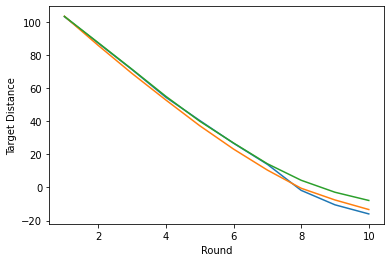

In [20]:
fig, ax = plt.subplots()
ax.plot(rounds, equal_evolution)
ax.plot(rounds, unequal_h_evolution)
ax.plot(rounds, unequal_l_evolution)

ax.set(xlabel='Round', ylabel='Target Distance',
       title='')
ax.grid(False)

fig.savefig("img/game_evolution.pdf")
plt.show()

#### Inequalties (Gini Coefficient)

In [21]:
# http://www.ellipsix.net/blog/2012/11/the-gini-coefficient-for-distribution-inequality.html
def gini_coeff(x):
    # requires all values in x to be zero or positive numbers,
    # otherwise results are undefined
    n = len(x)
    s = x.sum()
    r = np.argsort(np.argsort(-x)) # calculates zero-based ranks
    return 1 - (2.0 * (r*x).sum() + s)/(n*s)

In [22]:
equal_treatment = np.array([40, 40, 40, 40, 40, 40])
print('Gini coefficient Equal: {}'.format(gini_coeff(equal_treatment)))
unequal_H_treatment = np.array([60, 60, 30, 30, 30, 30])
print('Gini coefficient Unequal H: {}'.format(gini_coeff(unequal_H_treatment)))
unequal_L_treatment = np.array([48, 48, 48, 48, 24, 24])
print('Gini coefficient Unequal L: {}'.format(gini_coeff(unequal_L_treatment)))

for index, row in df_games.iterrows():
    if row['control_wealth'] == 'EQUAL':        
        gini_after = gini(df_users[df_users['partida_id'] == row['id']]['endowment_current'])
        df_games.loc[index, 'gini_after'] = gini_after
    
    if row['control_wealth'] == 'UNEQUAL-H':        
        gini_after = gini(df_users[df_users['partida_id'] == row['id']]['endowment_current'])
        df_games.loc[index, 'gini_after'] = gini_after
        
    if row['control_wealth'] == 'UNEQUAL-L':        
        gini_after = gini(df_users[df_users['partida_id'] == row['id']]['endowment_current'])
        df_games.loc[index, 'gini_after'] = gini_after
        
print('Average Gini Equal: {}'.format(np.mean(df_games[df_games['control_wealth']=='EQUAL']['gini_after'])))
print('Average Gini Unequal-H: {}'.format(np.mean(df_games[df_games['control_wealth']=='UNEQUAL-H']['gini_after'])))
print('Average Gini Unequal-L: {}'.format(np.mean(df_games[df_games['control_wealth']=='UNEQUAL-L']['gini_after'])))


Gini coefficient Equal: 0.0
Gini coefficient Unequal H: 0.16666666666666663
Gini coefficient Unequal L: 0.1333333333333333


NameError: name 'gini' is not defined

In [ ]:
# add stripplot to boxplot with Seaborn
bplot=sns.stripplot(x='control_wealth', y='gini_after',
                    orient = 'v',
                    data=df_games, 
                    jitter=True, 
                    marker='o', alpha=0.5, 
                    #palette=[blue_color, green_color], edgecolor=[blue_color, green_color], 
                    facecolors="none")


# make boxplot with Seaborn
bplot=sns.boxplot(x='control_wealth', # vertical
                  y='gini_after',
                  orient = 'v', 
                  data=df_games, 
                  width=.5, 
                  #palette=[blue_color, green_color], 
                  linewidth=1.5,
                  #showmeans=True
                )

for patch in bplot.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .25))

for i,artist in enumerate(bplot.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor(col)

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = bplot.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

bplot.set_ylim([0, 1]) 
plt.savefig('img/time_boxplot_log.pdf', format='pdf')


In [ ]:
#correlation matrix all columns
corrmat = df_users.corr()
#corrmat = df_users[['pollution_id','endowment_initial','contributed_public_goods','gender', 'age_range']].corr()

f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=20)
sns.heatmap(corrmat, vmin=-1, vmax=1, square=True, cmap=cmap);

In [ ]:
k = 5 #number of variables for heatmap
cols = corrmat.nlargest(k, 'contributed_public_goods')['contributed_public_goods'].index
cm = np.corrcoef(df_users[cols].values.T)
sns.set(font_scale=1.25)
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=20)
hm = sns.heatmap(cm, cbar=True, vmin=-1, vmax=1, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, cmap=cmap)
plt.show()